In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 600
predict_for = 14

In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
class Model:
  def __init__(self, df, epochs = 100):
    self.scaler = MinMaxScaler()
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)
    self.epochs = epochs

    self.model = Sequential()

    self.model.add(LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)))
    self.model.add(Dropout(0.1))
    self.model.add(LSTM(units = 32, return_sequences=True))
    self.model.add(Dropout(0.1))
    self.model.add(LSTM(units = 32))
    self.model.add(Dropout(0.1))
    self.model.add(Dense(units = 1))  #our predictions
    self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  def fit(self):
    y = self.dfy
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    self.model.fit(self.dfw, y, epochs = 100, callbacks=[callback])
    # self.model.fit(self.dfw, y, epochs = 100)
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p = [df_full]
    y_p = []

    for i in range(predict_for):
        yi = self.model.predict(np.array(X_p))
        y_p.append(yi[0][0])
        
        X_p = [np.append(X_p[0][1:], yi)]

    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
df=df.groupby(['Date']).agg({'F_pos': 'sum', 'M_pos': 'sum', 'T_pos':'sum', 'NIA_pos':'sum', 'new_case': 'sum'}).reset_index()
# df_f = df['F_pos'].values
# df_m = df['M_pos'].values
# df_t = df['T_pos'].values
# df_nia = df['NIA_pos'].values

# df = df_f + df_m + df_t + df_nia

date = df.iloc[train_for + 1]['Date']

df = df['new_case'].values

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.005 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal

In [ ]:
# df = smoothen(df, 3)

In [ ]:
df_train = df[:train_for]
df_test = df[train_for:train_for+predict_for]

In [ ]:
model = Model(np.array(df_train))

In [ ]:
model.fit()

Epoch 1/100
18/18 [==============================] - 8s 126ms/step - loss: 0.0234
Epoch 2/100
18/18 [==============================] - 2s 88ms/step - loss: 0.0089
Epoch 3/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0069
Epoch 4/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0042
Epoch 5/100
18/18 [==============================] - 1s 60ms/step - loss: 0.0043
Epoch 6/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0044
Epoch 7/100
18/18 [==============================] - 1s 60ms/step - loss: 0.0040
Epoch 8/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0037
Epoch 9/100
18/18 [==============================] - 1s 59ms/step - loss: 0.0033
Epoch 10/100
18/18 [==============================] - 1s 62ms/step - loss: 0.0042
Epoch 11/100
18/18 [==============================] - 1s 72ms/step - loss: 0.0039
Epoch 12/100
18/18 [==============================] - 1s 73ms/step - loss: 0.0037
Epoch 13/100
18/18 [====

In [ ]:
model.model.save("simpleLSTM.h5")

In [ ]:
y_pred = model.predict(predict_for)

1/1 [==============================] - 0s 24ms/step


In [ ]:
y_test = df_test

def mape_(p, a):
  assert(len(p) == len(a))
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100


print(mape_(y_pred, y_test))

28.668816518308777


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

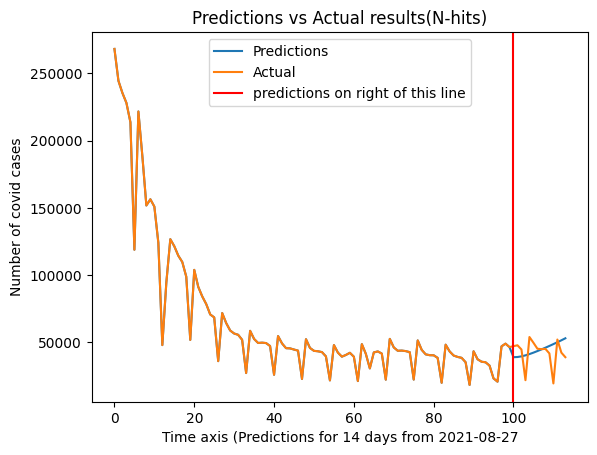

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results(N-hits)")
plt.plot(append(df[train_for - window:train_for], y_pred), label="Predictions")
plt.plot(append(df[train_for - window:train_for], y_test), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(y_pred)

[38959.348 39101.105 39592.465 40343.56  41281.605 42353.    43529.03
 44747.72  46023.75  47345.387 48704.906 50101.047 51537.453 53025.18 ]


In [ ]:
print(y_test)

[47165. 47824. 44686. 21877. 53981. 49711. 45260. 44952. 45153. 41752.
 19452. 52115. 42355. 38973.]
